# Spinvizualizáció tetszőleges rács esetén

In [137]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np

In [138]:
config_file = "input.cfg"
out_file = "out_q1.txt"

## Config fájl beolvasása

A config fájlból (ami alapján a szimuláció végbemegy) kinyerjük a vizualizációhoz szükséges adatokat, pl.: a rács alakja, mérete.

In [139]:
config = open(config_file)

# Számunkra fontos adatok
bravais_str = "bravais_vectors"
bravais_matrix = np.zeros((3, 3))

size_str = "n_basis_cells"
size = np.zeros(3)

# Beolvasás
for line in config:
    if bravais_str in line:
        for i in range(3):
            bravais_matrix[i] = config.readline().split(" ")[:3]
    if size_str in line:
        size = np.asarray(line.split(" ")[1:4]).astype(np.int64)
bravais_matrix = bravais_matrix.T

In [140]:
print(size)
x, y, z = size

[60 30  1]


### OVF fájl beolvasása

Az OVF fájlból ([OVF honlap](https://math.nist.gov/oommf/doc/userguide11b2/userguide/vectorfieldformat.html#:~:text=OOMMF%20stores%20vector%20field%20files,in%20binary%20and%20ASCII%20text.)), amit a [Spirit API](https://spirit-docs.readthedocs.io/en/latest/core/docs/python-api/API_Reference.html) kimeneteként kapunk meg, numpy tömböt generál.

Mivel  az adatok négyzetesek, ezért miden sor a vektor x, y, z komponensét tartalmazza.
A sorok sorrendje olyan, hogy x, y, z sorrendben növekszenek a helyek koordinátái.

Jó lenne csinálni egy Class-t ami minden fontos adatot tartalmaz

In [141]:
out = open(out_file)

# Ebből lehetne egy Class-t csinálni...

# Header rész
stepsize = np.zeros(3)
stepsize_string = ["# xstepsize:", "# ystepsize:", "# zstepsize:"]

bounds_string = [
    ["# xmin", "# xmax"],
    ["# ymin", "# ymax"],
    ["# zmin", "# zmax"]
]
bounds = np.zeros((3, 2), float)

# Data rész
f = "# Begin: Data Text"
l = "# End: Data Text"
is_data = False
data_lines = []
lattice = np.zeros((x, y, 3))

# koordináták tárolására
pos_arr = np.zeros((x , y, 3))
pos = np.zeros(3)

i = 0
j = 0
k = 0


for line in out:
    # Data és Header kettéválasztása
    if f in line:
        is_data = True
        continue
    elif l in line: is_data = False

    # Header
    if not is_data: 
        for i in range(3):
            if stepsize_string[i] in line:
                stepsize[i] = line.split(" ")[-1]

        for idx, s_str in np.ndenumerate(bounds_string):
            if s_str in line:
                # Ez nagyon rossz de működik
                bounds[idx[0]][idx[1]] = line.split(" ")[-1].split("\n")[0]
    
    # Data    
    else:
        line = line[:-2]
        data = line.split("       ")[1:]
        data_lines.append(data)
        lattice[i][j] = data
        pos_arr[i][j] = pos
        
        i = (i+1) % x
        if i == 0: 
            j = (j+1) % y
        if j == 0: 
            k = (k+1) % z

In [142]:
print(bounds[:2, :].flatten())

[0.      5.10955 0.      5.85   ]


In [143]:
out.close()
config.close()

## Vizualizáció

A transzformációt a bravis (sor)vektorokból álló mátrix adja meg. Ezeket használva transzformálom az adatokat majd plottolom őket.

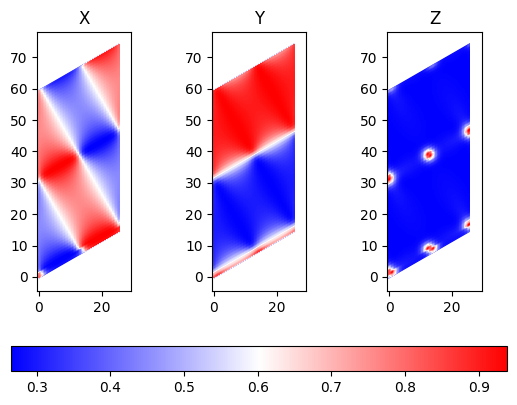

In [144]:
fig, ax = plt.subplots(1, 3)
koord = ["X", "Y", "Z"]

for i in range(3):
    im = ax[i].imshow(lattice[..., i], cmap='bwr' ,origin="lower")
    ax[i].set_title(koord[i])
    
    # Transzformáció
    trans_data = mtransforms.Affine2D(matrix=bravais_matrix) + ax[i].transData
    im.set_transform(trans_data)

    # Ez azért kell hogy a tengelyek jó méretűek legyenek
    x1, x2, y1, y2 = im.get_extent()
    ax[i].plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], transform=trans_data, alpha=0)

fig.colorbar(im, ax = ax, orientation='horizontal')